In [1]:
from pycalphad.model import TestModel
import pycalphad
import pycalphad.variables as v
from pycalphad.core.halton import halton
import numpy as np
rng = np.random.RandomState(1769)

In [2]:
def sample_quasi(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled quasi-randomly from a Halton sequence.
    A Halton sequence is like a uniform random distribution, but the
    result will always be the same for a given 'comp_count' and 'pdof'.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = halton(sum(comp_count),
                 pdof * (sum(comp_count) - len(comp_count)), scramble=True)
    # Convert low-discrepancy sequence to normalized exponential
    # This will be uniformly distributed over the simplices
    pts = -np.log(pts)
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
        cur_idx = end_idx

    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def sample_pseudo(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled pseudo-randomly from a symmetric
    Dirichlet distribution.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = np.empty((pdof * (sum(comp_count) - len(comp_count)), sum(comp_count), ))
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] = rng.dirichlet(np.ones(ctx, dtype=np.int),
                                                size=(pdof * (sum(comp_count) - len(comp_count))))
        cur_idx = end_idx
    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def test_opt(num_components, num_samples, sampler):
    result_array = np.empty((num_samples))
    comps = ['X{}'.format(i+1) for i in range(num_components)]
    for idx in range(num_samples):
        solution = rng.dirichlet(np.ones_like(comps, dtype=np.int))
        tm = TestModel(None, comps, 'TEST', solution=solution, kmax=2)
        dbf = pycalphad.Database()
        dbf.add_phase('TEST', {}, [1])
        dbf.add_phase_constituents('TEST', [comps])
        conds = {v.P:101325, v.T:300}
        conds.update({v.X(i):sol for i, sol in list(zip(comps, solution))[:-1]})
        grid_opts = {'sampler': sampler}
        eq = pycalphad.equilibrium(dbf, comps, 'TEST', conds, model=tm, verbose=False, grid_opts=grid_opts)
        if eq.GM < 10:
            result_array[idx] = eq.attrs['iterations']
        else:
            print(eq)
            print(solution)
            result_array[idx] = np.nan
    return result_array

In [3]:
%%time
comp_iters_pseudo = []
comp_iters_quasi = []
max_comps = 4
for num_comps in range(2, max_comps+1):
    results_pseudo = test_opt(num_comps, 25, sample_pseudo)
    results_quasi = test_opt(num_comps, 25, sample_quasi)
    comp_iters_pseudo.append(results_pseudo)
    comp_iters_quasi.append(results_quasi)
comp_iters_pseudo = np.array(comp_iters_pseudo, dtype=np.float)
comp_iters_quasi = np.array(comp_iters_quasi, dtype=np.float)

pycalphad ERROR 2016-01-27 13:50:27,563 [lower_convex_hull 266] Iterations exceeded


Iterations exceeded. Remaining driving force:  2.82921659719e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:50:27,647 [lower_convex_hull 266] Iterations exceeded


 2.82921659719e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:50:58,690 [lower_convex_hull 266] Iterations exceeded


 7.10015194817e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:50:58,775 [lower_convex_hull 266] Iterations exceeded


 7.10015194817e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:14,500 [lower_convex_hull 266] Iterations exceeded


 7.59736749358e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:14,626 [lower_convex_hull 266] Iterations exceeded


 1.05821659044e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:14,711 [lower_convex_hull 266] Iterations exceeded


 1.05821659044e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:46,231 [lower_convex_hull 266] Iterations exceeded


 4.39723565245e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:46,367 [lower_convex_hull 266] Iterations exceeded


 7.50796579598e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:46,453 [lower_convex_hull 266] Iterations exceeded


 7.50796579598e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:54,610 [lower_convex_hull 266] Iterations exceeded


 9.96050714949e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:54,752 [lower_convex_hull 266] Iterations exceeded


 2.47479264333e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:51:54,837 [lower_convex_hull 266] Iterations exceeded


 2.47479264333e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:52:04,825 [lower_convex_hull 266] Iterations exceeded


 3.60809759992e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:52:04,951 [lower_convex_hull 266] Iterations exceeded


 7.57157407344e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:52:05,034 [lower_convex_hull 266] Iterations exceeded


 7.57157407344e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:22,388 [lower_convex_hull 266] Iterations exceeded


 0.00274068047942
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:22,525 [lower_convex_hull 266] Iterations exceeded


 0.0063689085811
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:22,618 [lower_convex_hull 266] Iterations exceeded


 0.0063689085811
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:42,167 [lower_convex_hull 266] Iterations exceeded


 3.81352366657e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:42,301 [lower_convex_hull 266] Iterations exceeded


 3.74323052441e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:42,434 [lower_convex_hull 266] Iterations exceeded


 1.14417165082e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:42,560 [lower_convex_hull 266] Iterations exceeded


 1.55382458747e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:53:42,645 [lower_convex_hull 266] Iterations exceeded


 1.55382458747e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:54:00,754 [lower_convex_hull 266] Iterations exceeded


 1.31930971909e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:54:00,838 [lower_convex_hull 266] Iterations exceeded


 1.31930971909e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:55:00,633 [lower_convex_hull 266] Iterations exceeded


 6.34290123562e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:55:00,770 [lower_convex_hull 266] Iterations exceeded


 7.19170718255e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:55:00,864 [lower_convex_hull 266] Iterations exceeded


 7.19170718255e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:55:19,171 [lower_convex_hull 266] Iterations exceeded


 6.64001476392e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:55:19,257 [lower_convex_hull 266] Iterations exceeded


 6.64001476392e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:12,076 [lower_convex_hull 266] Iterations exceeded


 1.2437542027e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:12,202 [lower_convex_hull 266] Iterations exceeded


 1.4574819291e-05
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:12,329 [lower_convex_hull 266] Iterations exceeded


 3.55664341043e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:12,455 [lower_convex_hull 266] Iterations exceeded


 4.60946202602e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:12,540 [lower_convex_hull 266] Iterations exceeded


 4.60946202602e-06
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:31,528 [lower_convex_hull 266] Iterations exceeded


 2.71813849835e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:31,660 [lower_convex_hull 266] Iterations exceeded


 3.89919052055e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:31,744 [lower_convex_hull 266] Iterations exceeded


 3.89919052055e-07
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:50,050 [lower_convex_hull 266] Iterations exceeded


 4.38915566007e-05
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:50,176 [lower_convex_hull 266] Iterations exceeded


 6.45463751322e-05
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-27 13:56:50,258 [lower_convex_hull 266] Iterations exceeded


 6.45463751322e-05
CPU times: user 15min 37s, sys: 20min 25s, total: 36min 3s
Wall time: 11min 2s


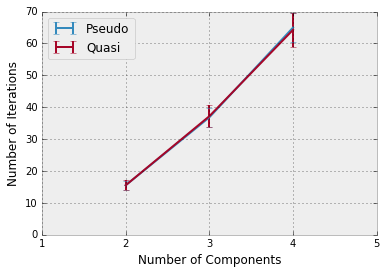

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
ax = plt.figure()
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_pseudo, axis=1),
             yerr=np.nanstd(comp_iters_pseudo, axis=1), label='Pseudo')
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_quasi, axis=1),
             yerr=np.nanstd(comp_iters_quasi, axis=1), label='Quasi')
plt.ylim((0,None))
plt.xticks(list(range(1, max_comps+2)))
plt.xlabel('Number of Components')
plt.ylabel('Number of Iterations')
plt.legend(loc='best')
plt.show()

In [5]:
comp_iters_quasi

array([[ 15.,  13.,  18.,  14.,  14.,  16.,  17.,  17.,  14.,  18.,  13.,
         17.,  15.,  16.,  16.,  15.,  14.,  14.,  17.,  13.,  16.,  17.,
         17.,  16.,  16.],
       [ 38.,  40.,  42.,  37.,  41.,  37.,  42.,  37.,  33.,  39.,  34.,
         35.,  40.,  42.,  32.,  33.,  35.,  33.,  36.,  36.,  45.,  36.,
         38.,  31.,  38.],
       [ 66.,  66.,  47.,  69.,  68.,  59.,  61.,  75.,  66.,  66.,  62.,
         64.,  64.,  70.,  57.,  60.,  66.,  67.,  67.,  64.,  63.,  65.,
         67.,  69.,  59.]])

In [6]:
comp_iters_pseudo

array([[ 15.,  16.,  17.,  16.,  18.,  17.,  15.,  18.,  15.,  16.,  14.,
         15.,  14.,  17.,  15.,  14.,  16.,  16.,  15.,  15.,  16.,  17.,
         12.,  15.,  14.],
       [ 40.,  35.,  34.,  40.,  42.,  39.,  33.,  41.,  35.,  35.,  39.,
         39.,  33.,  42.,  39.,  36.,  35.,  32.,  34.,  35.,  40.,  39.,
         32.,  35.,  37.],
       [ 68.,  71.,  68.,  73.,  72.,  63.,  60.,  59.,  66.,  62.,  63.,
         66.,  59.,  61.,  69.,  65.,  58.,  62.,  61.,  63.,  68.,  62.,
         67.,  65.,  74.]])